In [1121]:
import pandas as pd

In [1122]:
import seaborn as sns

In [1123]:
import numpy as np

In [1124]:
from nilearn import image

In [1125]:
import scipy.stats as ss

In [1126]:
mask_l = '/data/odc/derivatives/pycortex/masks/sub-tk/sub-tk_desc-V1l_gm_mask.nii.gz'
mask_r = '/data/odc/derivatives/pycortex/masks/sub-tk/sub-tk_desc-V1r_gm_mask.nii.gz'

mask_bold = '/data/flicker/derivatives/spynoza/sub-tk/ses-flicker1/func/sub-tk_ses-flicker1_task-flicker_acq-0p93_run-01_mask.nii.gz'

mask_l = image.resample_to_img(mask_l, mask_bold, interpolation='nearest')
mask_r = image.resample_to_img(mask_r, mask_bold, interpolation='nearest')

mask = image.math_img('((mask_l + mask_r) > 0) & (mask_bold == 1)', mask_l=mask_l, mask_r=mask_r, mask_bold=mask_bold)

In [1127]:
from scipy import ndimage

In [1128]:
mask = image.new_img_like(mask, ndimage.binary_dilation(mask.get_data(), iterations=2))

In [1129]:
mask.to_filename('/data/flicker/zooi/mask.nii.gz')

In [1130]:
from nilearn.input_data import NiftiMasker

In [1131]:
masker = NiftiMasker(mask)

In [1132]:
import glob
import re

In [1133]:
fns = glob.glob('/data/flicker/derivatives/modelfitting/glm8/sub-tk/ses-flicker1/func/sub-tk_ses-flicker1_task-flicker_run-*_freq-*_psc.nii.gz')

In [1134]:
reg = re.compile('.*/sub-(?P<subject>.+)/ses-(?P<session>.+)/func/sub-.+_ses-.+_task-(?P<task>.+)_run-(?P<run>[0-9]+)_freq-(?P<frequency>.+)_psc\.nii\.gz')

<>:1: DeprecationWarning: invalid escape sequence \.


In [1135]:
df = []
for fn in fns:
    df.append(pd.DataFrame(masker.fit_transform(fn)))
    
    meta = reg.match(fn).groupdict()
    df[-1] = pd.concat((df[-1], pd.DataFrame([meta])), keys=['data', 'meta'], axis=1)

/Users/gilles/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [1136]:
df = pd.concat(df)

In [1137]:
df.index = np.arange(len(df))

In [1138]:
df[('meta', 'frequency')] = df[('meta', 'frequency')].astype(float)

In [1139]:
df[('meta', 'log(frequency)')] = np.log10(df['meta']['frequency'])

/Users/gilles/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [1140]:
df.shape

(35, 9119)

In [1141]:
import sharedmem
from tqdm import tqdm_notebook as tqdm

In [1144]:
with sharedmem.MapReduce(np=4) as pool:
    
    def init_voxel(d):

        ix = df['meta', 'frequency'] != 0    

        weighted_mean = (d.loc[ix] * df['meta'].loc[ix, 'log(frequency)']).sum() / ix.sum()
        weighted_sd = np.sqrt(((d.loc[ix] * (df['meta'].loc[ix, 'log(frequency)'] - weighted_mean))**2).sum() / ix.sum())

        baseline = d.loc[~ix].mean()
        
        amplitude = (d.max() - baseline)

        return weighted_mean, weighted_sd, baseline, amplitude
    
    def cost(pars, d):

        mean, sd, offset, amplitude = pars     
        
        normalize = ss.norm(mean, sd).pdf(mean)
        
        pred = ss.norm(mean, sd).pdf(df['meta'].loc[:, 'log(frequency)']) / normalize * amplitude + offset

        return (d - pred).var()
    
    def fit_voxel(voxel_id):

        d = df['data'].loc[:, voxel_id]

        if d.var() == 0:
             return pd.Series({'mean_log':0,
                          'mean_sd':0,
                          'mean':0,                               
                          'amplitude':0,
                          'residual':0,                               
                          'offset':0,
                          'amplitude':0,
                          'r2': 0})


        mean, sd, baseline, amplitude = init_voxel(d)
        r = optimize.minimize(cost, (mean, sd, baseline, amplitude), 
                              bounds=[(np.log10(0.05), np.log10(200)),
                                      (1e-9, np.log10(100)),
                                      (-100, 100),
                                      (0, 100)],
                                      args=(d,))

        return pd.Series({'mean_log':r.x[0],
                          'mean_sd':r.x[1],
                          'offset':r.x[2],
                          'amplitude':r.x[3],
                          'mean':np.exp(r.x[0]),
                          'residual':r.fun,
                          'var':d.var(),
                          'r2':1 - (r.fun / d.var())})    

    pb = tqdm(total=df.shape[1])

    def reduce(r):
        pb.update()
        return r

    args = df['data'].columns
    optim_results = pool.map(fit_voxel, args, reduce=reduce)

In [1145]:
results = pd.concat(optim_results, axis=1)

/Users/gilles/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [1188]:
results.loc['mean'] = 10**results.loc['mean_log']

In [1189]:
results.T.describe()

,amplitude,mean,mean_log,mean_sd,offset,r2,residual,var
count,9113.000000,9113.000000,9113.000000,9.113000e+03,9113.000000,9.113000e+03,9113.000000,7257.000000
mean,2.647324,33.591267,0.587171,4.179008e-01,-0.356119,7.630599e-02,22.608499,29.540406
std,4.343244,65.487271,1.058734,5.603796e-01,1.994452,1.292975e-01,1656.074741,1884.677550
min,0.000000,0.050000,-1.301030,0.000000e+00,-78.495956,-1.954431e-07,0.000000,0.312830
25%,0.000000,1.000000,0.000000,1.000000e-09,-0.508535,0.000000e+00,0.979815,2.188103
50%,1.411409,5.502490,0.740559,9.003625e-02,-0.132343,1.538385e-02,2.526030,3.625475
75%,3.420068,16.183550,1.209074,6.204359e-01,0.000000,1.008685e-01,4.913456,6.393855
max,100.000000,200.000000,2.301030,2.000000e+00,53.305458,8.727733e-01,157923.109238,160366.795327


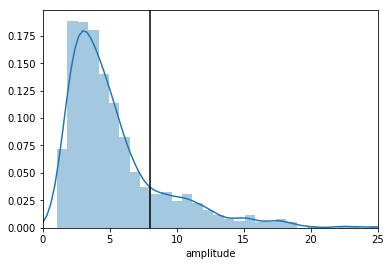

In [1191]:
sns.distplot(results.loc[:, results.loc['r2'] > .25].loc['amplitude'])
plt.xlim(0, 25)
plt.axvline(8, c='k')

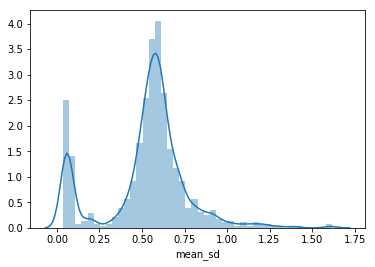

In [1192]:
sns.distplot(results.loc[:, results.loc['r2'] > .25].loc['mean_sd'])
# plt.xlim(0, 25)
# plt.axvline(8, c='k')

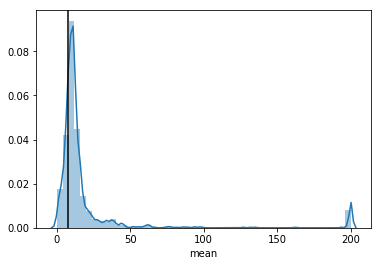

In [1272]:
sns.distplot(results.loc[:, results.loc['r2'] > .15].loc['mean'])
# plt.xlim(0, 100)
plt.axvline(8, c='k')

/Users/gilles/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


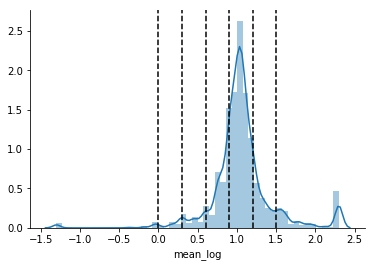

In [1342]:
sns.distplot(results.loc[:, results.loc['r2'] > .15].loc['mean_log'])
# plt.xlim(0, 100)
for freq in df['meta']['frequency'].unique():
    plt.axvline(np.log10(freq), c='k', ls='--')
    
sns.despine()

(0, 1.5)

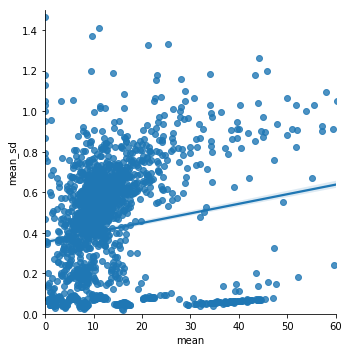

In [1507]:
sns.lmplot('mean', 'mean_sd', data=results.T[results.T['r2'] > 0.1])
plt.xlim(0, 60)
plt.ylim(0, 1.5)

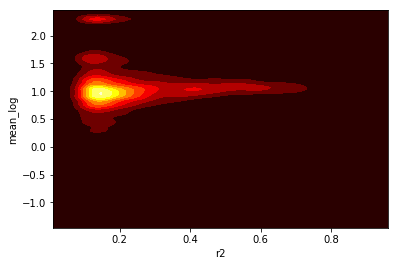

In [1513]:
tmp = results.T[results.T['r2'] > 0.1]
sns.kdeplot(tmp['r2'], tmp['mean_log'], shade=True, cmap='hot')

In [1514]:
10**1.5

31.622776601683793

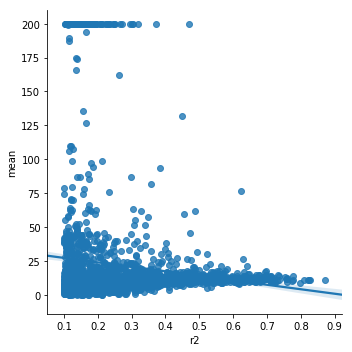

In [1509]:
sns.lmplot('r2', 'mean', data=results.T[results.T['r2'] > 0.1])
# plt.xlim(0, 60)
# plt.ylim(0, 1.5)

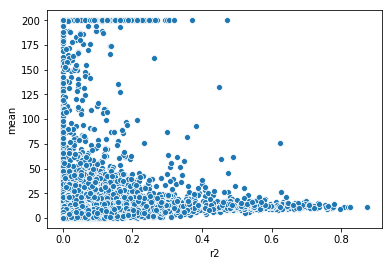

In [1194]:
sns.scatterplot('r2', 'mean', data=results.T)

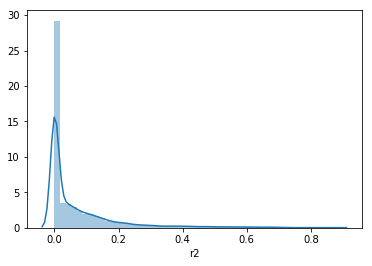

In [1195]:
sns.distplot(results.loc[:, results.loc['r2'] < 1].loc['r2'])

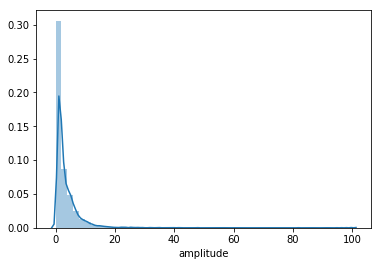

In [1196]:
sns.distplot(results.loc['amplitude'])
# plt.xlim(0, 25)

In [1197]:
for ix, row in results.iterrows():
    masker.inverse_transform(row).to_filename(f'/data/flicker/zooi/pars_{ix}.nii.gz')
    
    row_ = row.copy()
    row_[results.loc['r2'] < 0.1] = 0
    masker.inverse_transform(row_).to_filename(f'/data/flicker/zooi/pars_{ix}_thr.nii.gz')
    

/Users/gilles/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [1198]:
depth_l = '/data/odc/derivatives/nighres/sub-tk/ses-anat/anat/sub-tk_ses-anat_space-average_desc-layer_depth_hemi-left_depth.nii.gz'
depth_r = '/data/odc/derivatives/nighres/sub-tk/ses-anat/anat/sub-tk_ses-anat_space-average_desc-layer_depth_hemi-right_depth.nii.gz'
depth = image.math_img('depth_l + depth_r', depth_l=depth_l, depth_r=depth_r)

In [1199]:
left_hemi = (pd.Series(masker.fit_transform(mask_l)[0]) > 0) * 1.
right_hemi = (pd.Series(masker.fit_transform(mask_r)[0]) > 0) * 2

In [1200]:
hemisphere = (left_hemi + right_hemi).map({1.:'left', 2.:'right'})

In [1201]:
pars_hires = image.resample_to_img(masker.inverse_transform(results), depth, interpolation='nearest')

/Users/gilles/miniconda3/lib/python3.7/site-packages/nilearn/image/resampling.py:543: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)


In [1202]:
depth_df = pd.DataFrame(masker.fit_transform(depth), index=['depth'])
pars_df = pd.DataFrame(masker.fit_transform(pars_hires), index=results.index)



/Users/gilles/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/Users/gilles/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/Users/gilles/miniconda3/lib/python3.7/site-packages/nilearn/image/resampling.py:543: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)


In [1397]:
df_hires = pd.concat((depth_df, pars_df, pd.DataFrame([hemisphere], index=['hemi'])))

In [1398]:
df_hires = df_hires.T

In [1399]:
df_hires = df_hires[df_hires.depth != 0]

In [1400]:
# df_hires = df_hires[df_hires['r2'] > 0.25]

In [1401]:
df_hires['mean_log'] = df_hires['mean_log'].astype(float)

In [1402]:
# df_hires = df_hires[df_hires['mean'] < 60]

In [1472]:
r2_thr = 0.15
ix = df_hires['r2'] > r2_thr

In [1473]:
df_hires.loc[ix].shape

(1213, 12)

In [1474]:
df_hires['depth_q'] = pd.qcut(df_hires.loc[ix, 'depth'], 3, labels=[f'q{i}' for i in range(1, 4)])

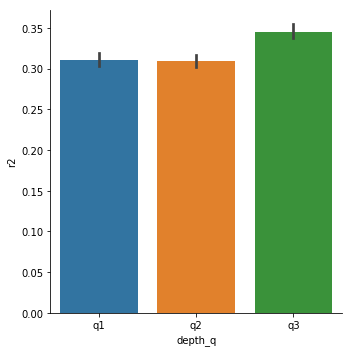

In [1475]:
sns.catplot('depth_q', 'r2', data=df_hires.loc[ix], kind='bar', ci=67)

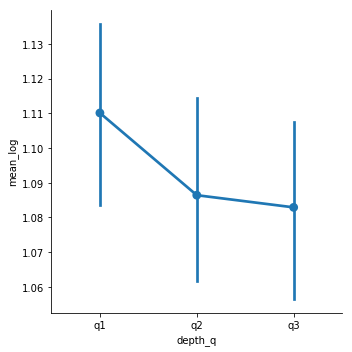

In [1476]:
sns.catplot('depth_q', 'mean_log', data=df_hires.loc[ix], kind='point', ci=67)

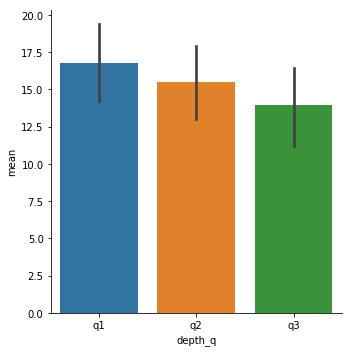

In [1477]:
sns.catplot('depth_q', 'mean', data=df_hires.loc[ix], kind='bar', ci=67)

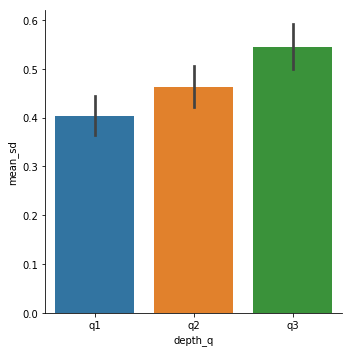

In [1478]:
sns.catplot('depth_q', 'mean_sd', data=df_hires.loc[ix], kind='bar')

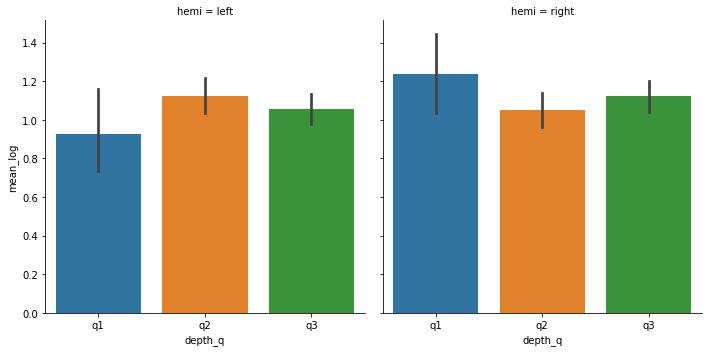

In [1479]:
sns.catplot('depth_q', 'mean_log', data=df_hires.loc[ix], col='hemi', kind='bar')

In [1492]:
df_hires['r2'] = df_hires['r2'].astype('float')
df_hires['mean'] = df_hires['mean'].astype('float')

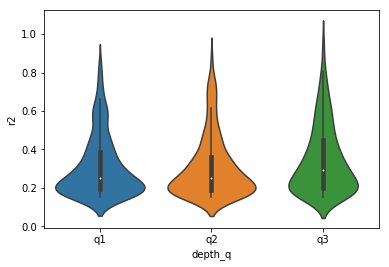

In [1493]:
sns.violinplot('depth_q', 'r2', data=df_hires)

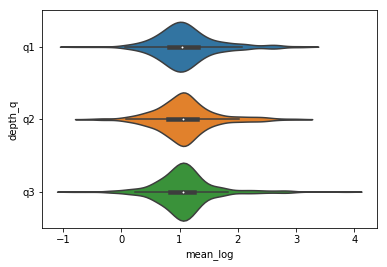

In [1482]:
sns.violinplot('mean_log', 'depth_q', data=df_hires, bw=.25)

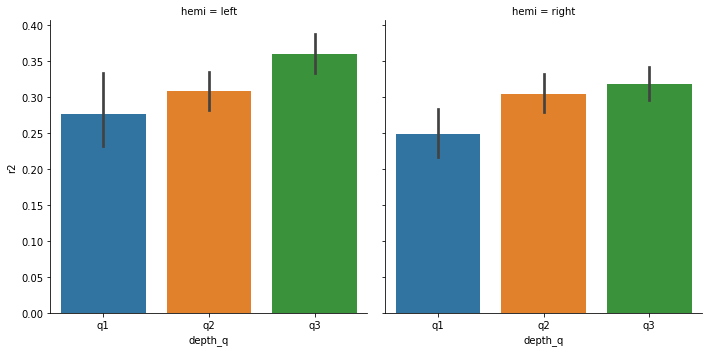

In [1483]:
sns.catplot('depth_q', 'r2', data=df_hires, col='hemi', kind='bar')

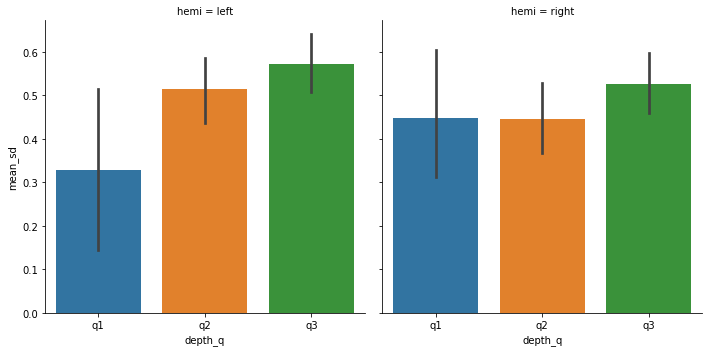

In [1484]:
sns.catplot('depth_q', 'mean_sd', data=df_hires, col='hemi', kind='bar')

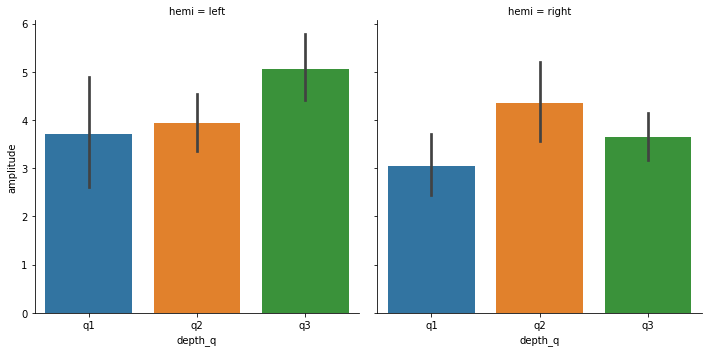

In [1485]:
sns.catplot('depth_q', 'amplitude', data=df_hires, col='hemi', kind='bar')

In [1486]:
df_hires['r2_q'] = pd.qcut(df_hires['r2'], 5, labels=[f'q{i}' for i in range(1, 6)])

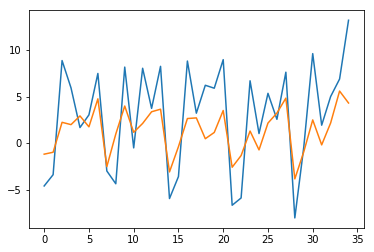

In [1487]:
plt.plot(df['data'][5868])
plt.plot(df['data'][2650])

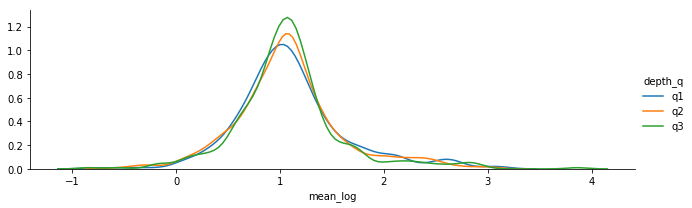

In [1488]:
fac =sns.FacetGrid(df_hires, hue='depth_q', aspect=3)
fac.map(sns.distplot, 'mean_log', hist=False)
fac.add_legend()

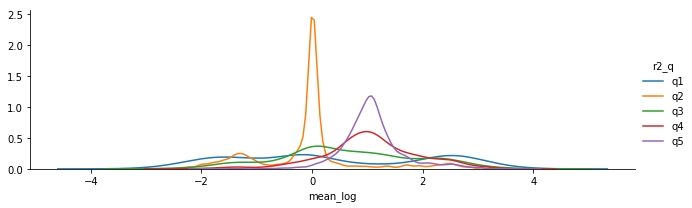

In [1489]:

fac =sns.FacetGrid(df_hires, hue='r2_q', aspect=3)
fac.map(sns.distplot, 'mean_log', hist=False)
fac.add_legend()

In [1490]:
df_hires.groupby(['depth_q']).mean()

,mean,mean_log,r2
depth_q,,,
q1,16.762564,1.110112,0.310882
q2,15.528865,1.086402,0.308996
q3,13.966000,1.082892,0.345442


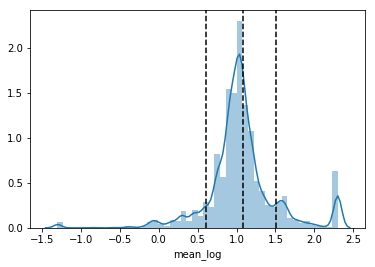

In [1491]:
fac = sns.distplot(results.loc['mean_log', results.loc['r2'] > 0.1])
plt.axvline(np.log10(32), c='k', ls='--')
plt.axvline(np.log10(12), c='k', ls='--')
plt.axvline(np.log10(4), c='k', ls='--')
# fac.set_xscale('log')

In [ ]:
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')

g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')